# BULB CODING CHALLENGE

An analysis of member referrals at Bulb is requested. A sample dataset is provided with customer sign up meta data consisting of sign up dates, sign up channels, refferer, referral date

The ask is for analysing the data with a goal of suggesting methods to increase member referrals 

### Load Sample Data

In [108]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn import preprocessing as prep
import seaborn as sns

In [5]:
cust=pd.read_csv('180601_Customer_Info.csv')

In [6]:
cust.head()

,customer_id,sign_up_date,sign_up_channel
0,2543,2021-04-26,Price Comparison Website
1,2181,2021-07-24,Referral
2,2399,2020-10-11,Bulb Website
3,674,2021-04-04,Referral
4,2332,2021-09-05,Price Comparison Website


In [7]:
reff=pd.read_csv('180601_Referrals_Info.csv')

In [8]:
reff.head()

,referral_date,referrer_customer_id,sign_up_customer_id
0,2021-07-18,795,1771
1,2021-04-12,577,1510
2,2021-07-07,868,1858
3,2021-10-25,801,1778
4,2021-08-15,690,1637


### Investigate Sample Data

In [12]:
cust.sign_up_date.min()

'2019-05-07'

In [13]:
cust.sign_up_date.max()

'2022-01-03'

Customer information is over the span of *972 days from the first date to the last date, but not including the last date.
Or 2 years, 7 months, 27 days excluding the last date. Or 31 months, 27 days excluding the last date* 

Sign up dates in the future suggest this is not real data. But assuming that Bulb has been around for 5 years, it is a faily large sample

In [14]:
reff.referral_date.min()

'2020-03-13'

In [15]:
reff.referral_date.max()

'2022-01-03'

In [20]:
cust['sign_up_channel'].unique().tolist()

['Price Comparison Website', 'Referral', 'Bulb Website']

In [158]:
cust.groupby(['sign_up_channel']).size()

sign_up_channel
Bulb Website                354
Price Comparison Website    780
Referral                    565
dtype: int64

Text(0.5,1,'Sign-ups by Channel')

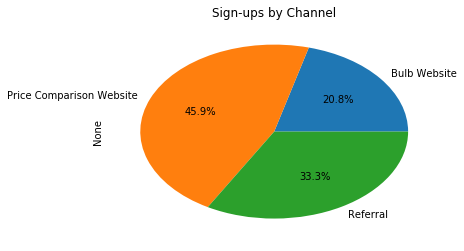

In [169]:
cust.groupby(['sign_up_channel']).size().plot.pie(autopct='%1.1f%%')
plt.title("Sign-ups by Channel")

The highest number of sign ups are from Price Comparison websites followed by referrals and then the Bulb website. There is scope for increasing sign ups through increased visibility of the website.

In [41]:
cust[cust['customer_id'].duplicated(keep=False)]

,customer_id,sign_up_date,sign_up_channel
53,116,2020-05-07,Price Comparison Website
1380,116,2020-10-27,Bulb Website


One duplicate entry for customer sign ups exists with very different sign up dates. This is perhaps erroneous data or recycled customer id. We will include this entry in our analysis

In [43]:
reff[reff['sign_up_customer_id'].duplicated(keep=False)]

,referral_date,referrer_customer_id,sign_up_customer_id


In [65]:
multref = reff[reff.groupby('referrer_customer_id')['sign_up_customer_id'].transform('size') > 1]
multref = multref.groupby('referrer_customer_id')['sign_up_customer_id'].nunique()
print(multref)

referrer_customer_id
6      11
8      34
10      9
34      4
36      9
37      8
54      7
69      2
71      2
116     2
117     6
124     2
131     2
133     5
140     4
147     4
155     4
178     2
214     6
215     2
234     2
264     3
292     2
322     3
332     4
340     3
352     4
373     2
510     2
516     2
531     3
544     2
575     2
616     2
652     2
655     2
709     2
725     2
Name: sign_up_customer_id, dtype: int64


Customer 8 has reffered 34 people. This along with customers 6,10,36,37,54 are outliers

In [148]:
custref = pd.merge(reff, cust, left_on='referrer_customer_id', right_on='customer_id',how='inner')
custref.head()

,referral_date,referrer_customer_id,sign_up_customer_id,customer_id,sign_up_date,sign_up_channel
0,2021-07-18,795,1771,795,2021-03-03,Price Comparison Website
1,2021-04-12,577,1510,577,2021-03-28,Price Comparison Website
2,2021-07-07,868,1858,868,2021-03-07,Bulb Website
3,2021-10-25,801,1778,801,2021-04-30,Referral
4,2021-08-15,690,1637,690,2021-07-29,Price Comparison Website


In [149]:
custref.shape

(832, 6)

832 signed up customers are available on the referral data

In [175]:
custref['referral_date'] = pd.to_datetime(custref['referral_date'], format='%Y-%m-%d')
custref['sign_up_date'] = pd.to_datetime(custref['sign_up_date'], format='%Y-%m-%d')
custref['days_to_referral']=custref['referral_date']-custref['sign_up_date']

In [176]:
custref.head()

,referral_date,referrer_customer_id,sign_up_customer_id,customer_id,sign_up_date,sign_up_channel,days_to_referral
0,2021-07-18,795,1771,795,2021-03-03,Price Comparison Website,137 days
1,2021-04-12,577,1510,577,2021-03-28,Price Comparison Website,15 days
2,2021-07-07,868,1858,868,2021-03-07,Bulb Website,122 days
3,2021-10-25,801,1778,801,2021-04-30,Referral,178 days
4,2021-08-15,690,1637,690,2021-07-29,Price Comparison Website,17 days


In [177]:
mean_ref_time=custref['days_to_referral'].dt.days.mean()
print(mean_ref_time)

113.65384615384616


In [178]:
std_ref_time=custref['days_to_referral'].dt.days.std()
print(std_ref_time)

112.99626900165335


The standard deviation around the mean is high

In [179]:
scaler = prep.MinMaxScaler()
custref['refdays_score']=scaler.fit_transform(custref.days_to_referral.to_numpy().reshape(-1,1))
custref.head()

C:\Users\murfe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype timedelta64[ns] was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,referral_date,referrer_customer_id,sign_up_customer_id,customer_id,sign_up_date,sign_up_channel,days_to_referral,refdays_score
0,2021-07-18,795,1771,795,2021-03-03,Price Comparison Website,137 days,0.195714
1,2021-04-12,577,1510,577,2021-03-28,Price Comparison Website,15 days,0.021429
2,2021-07-07,868,1858,868,2021-03-07,Bulb Website,122 days,0.174286
3,2021-10-25,801,1778,801,2021-04-30,Referral,178 days,0.254286
4,2021-08-15,690,1637,690,2021-07-29,Price Comparison Website,17 days,0.024286


In [184]:
custref['calcdaystoref']=(custref['days_to_referral'].dt.days-mean_ref_time)/std_ref_time
custref.head()

,referral_date,referrer_customer_id,sign_up_customer_id,customer_id,sign_up_date,sign_up_channel,days_to_referral,refdays_score,calcdaystoref
0,2021-07-18,795,1771,795,2021-03-03,Price Comparison Website,137 days,0.195714,0.206610
1,2021-04-12,577,1510,577,2021-03-28,Price Comparison Website,15 days,0.021429,-0.873072
2,2021-07-07,868,1858,868,2021-03-07,Bulb Website,122 days,0.174286,0.073862
3,2021-10-25,801,1778,801,2021-04-30,Referral,178 days,0.254286,0.569454
4,2021-08-15,690,1637,690,2021-07-29,Price Comparison Website,17 days,0.024286,-0.855372


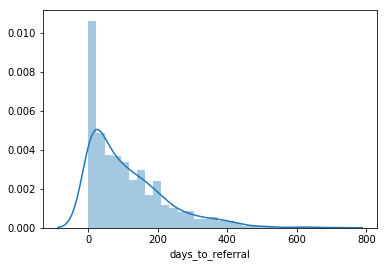

In [204]:
sns.distplot(custref['days_to_referral'].dt.days,bins=30)
#sns.distplot(custref['days_to_referral'].dt.days, norm_hist=False, kde=False)  
#custref['days_to_referral'].max()

In [208]:
custref['days_to_referral'].median()

Timedelta('83 days 12:00:00')

Most referrals seem to happen within the 0 - 230 range with a median of 83 days since sign up

In [124]:
custref.to_csv('custref.csv')

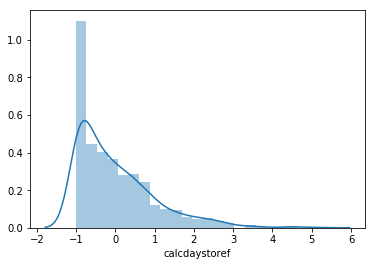

In [185]:
sns.distplot(custref['calcdaystoref'])  

In [186]:
scaler = prep.StandardScaler()
custref['stdscl_refdays']=scaler.fit_transform(custref.days_to_referral.to_numpy().reshape(-1,1))
custref.head()

C:\Users\murfe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype timedelta64[ns] was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,referral_date,referrer_customer_id,sign_up_customer_id,customer_id,sign_up_date,sign_up_channel,days_to_referral,refdays_score,calcdaystoref,stdscl_refdays
0,2021-07-18,795,1771,795,2021-03-03,Price Comparison Website,137 days,0.195714,0.206610,0.206734
1,2021-04-12,577,1510,577,2021-03-28,Price Comparison Website,15 days,0.021429,-0.873072,-0.873597
2,2021-07-07,868,1858,868,2021-03-07,Bulb Website,122 days,0.174286,0.073862,0.073907
3,2021-10-25,801,1778,801,2021-04-30,Referral,178 days,0.254286,0.569454,0.569796
4,2021-08-15,690,1637,690,2021-07-29,Price Comparison Website,17 days,0.024286,-0.855372,-0.855887


Since there are extremely large outliers beyond standard deviation of 1, we will plot feature with min max scaling. Min max scaling also provides the added advantage of standardising the lifecycle between 0 and 1 for the current 2-3 year timeframe being examined

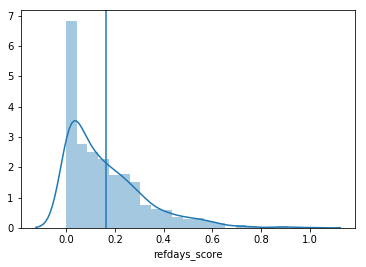

In [211]:
ax=sns.distplot(custref['refdays_score']) 
ax.axvline(custref['refdays_score'].mean())
plt.show()

In [199]:
custref['refdays_score'].mean()

0.16236263736263748

The above data shows that on average, people make a referral within the first 16% of their lifecycle - which equates to roughly 113 days for the sample dataset. This is based on the assumption that the data represents 100% of customer lifecycle

In [200]:
custref.groupby(['sign_up_channel'])['refdays_score'].mean()

sign_up_channel
Bulb Website                0.201751
Price Comparison Website    0.203191
Referral                    0.128161
Name: refdays_score, dtype: float64

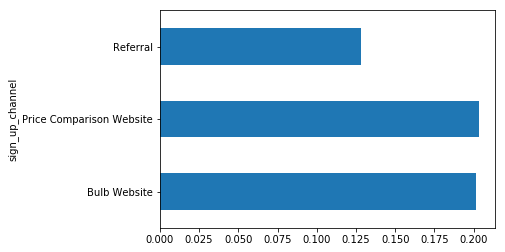

In [209]:
custref.groupby(['sign_up_channel'])['refdays_score'].mean().plot.barh()

In [210]:
custref.groupby(['sign_up_channel']).size()

sign_up_channel
Bulb Website                195
Price Comparison Website    188
Referral                    449
dtype: int64

### Conclusions

#### Sample Data Limitations

- Bulb is a high growth firm and the customer numbers and demographic is prone to change heavily as new members sign up. Customer demographic data of new sign ups will give us more confidence on inferences made here if the demographics are stable
- Sample data will need to be scrubbed further for outliers such as customers that have referred a relatively large number of sign ups. For example, the days taken by customer 8 to make multiple referrals could be reduced to a single mean value or removing the customers that took more than a year (365 days) to refer 
- Sample data is spread across 2 years and 8 months for sign ups and roughly 2 years for referrals. These two datasets are assumed to be mutually consistent when obtained (ie. represent the same time interval or that referral data was obtained using sign up data for that time interval)
- Large outliers in the time to referral feature suggest the distributions of referral times has too high a standard deviation (112 days) and cannot be normalised. This can be fixed with injecting more data from population into this model
- As Bulb is only 5 years old and this data covers roughly half that time and still has a high variance, more data will need to be systematically obtained for a more precise measurement with a low variance
- It is also not very clear from the data provided what "today's" date is - so that current vaules of lifetimes could be gauged

#### Inferences
Taking the limitations of sample data into account including any biases

##### When do members refer?
- The mean time taken for a customer to refer another customer from the day they sign up is within 4/25 of their lifespan or within the first 16 days if their lifetime was normalised to a 100 days. The mean time taken for customers to make a referral is 113 days with a median of 83 days

##### Who refers the most?
- The sample data suggests that members who are signed up through referrals seem to be the ones more likely to refer sooner than the ones aquired via websites
- Referral acquired customers also refer the most compared with ones acquired on websites

##### Email strategy
- Targetted emails about referrals should be sent at the end of the first 3 months (first quarter) of their life with Bulb and until about 7 months (230 days). This is the interval with most referrals
- Customers obtained via referrals should be targetted with a campaign/offer
- A hypothesis testing model or regression model can be created to learn real time from additional data and automate the email broadcast